In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models
from torchvision import transforms

from PIL import Image

import torch.autograd as autograd

import os

from matplotlib import pyplot as plt

import json

#delete

In [2]:
class ImageData(Dataset):
    def __init__(self, path, transforms=None):
        self.path = path
        self.transforms = transforms
        
        self.filenames = [n for n in os.listdir(self.path)]
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.path, self.filenames[idx])
        image = Image.open(img_name).convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)
            
        return dict(name=self.filenames[idx], image=image)
    

def get_images_dataloader(path, batch_size, transforms=None, num_workers=5):
    dataset = ImageData(path, transforms)
    return DataLoader(
        dataset,
        batch_size,
        num_workers=num_workers,
        drop_last=True
    )


def get_images_transforms(perturbation=None):
    tr = [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
    
    if perturbation is not None:
        tr.insert(2, transforms.Lambda(lambda x: x + perturbation))
        tr.insert(3, transforms.Lambda(lambda x: torch.clamp(x, 0, 1)))
    
    return transforms.Compose(tr)


def get_idx2label_map(labels_json_path):
    with open(labels_json_path) as f:
        j = json.load(f)
    
    idx2label = {}
    for k, v in j.items():
        idx2label[int(k)] = v[1]
    return idx2label

In [3]:
class ModelFeatureExtracter(nn.Module):
    def __init__(self, model, layer):
        super().__init__()
        self.model = model
        self.layer = layer
        self.model.eval()
        
    def extract_layer_output(self, x):
        outputs = []
        def extracting_hook(module, input, output):
            outputs.append(output)
        
        hook_handle = self.layer.register_forward_hook(extracting_hook)
        
        self.model(x)
        
        hook_handle.remove()
        return outputs[-1]
    
    def forward(self, x):
        with torch.no_grad():
            return self.model(x)

In [4]:
class JacobianOperator:
    def __init__(self, img_batch, model_feature_extractor, input_dim, hidden_dim, device=torch.device('cpu')):
        self.img_batch = img_batch
        self.mfe = model_feature_extractor
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        
    def _matvec_grad(self, img, vec):
        w = torch.zeros(self.hidden_dim, requires_grad=True).to(self.device)
        matvec_transposed = self._matvec_T_grad(img, w)
        dotproduct = torch.matmul(matvec_transposed.flatten(), vec.flatten())
        return autograd.grad(dotproduct, w)[0]

    def _matvec_T_grad(self, img, vec):
        img.requires_grad = True
        layer_output = self.mfe.extract_layer_output(img)
        dotproduct = torch.matmul(layer_output.flatten(), vec.flatten())
        return autograd.grad(dotproduct, img, create_graph=True)[0]
    
    def matvec(self, vec):
        output = []
        for img in self.img_batch:
            output.append(self._matvec_grad(img.unsqueeze(0), vec))
        return torch.cat(output)
    
    def matvec_T(self, vec):
        output = torch.zeros(self.input_dim).to(self.device)
        vec_flatten = vec.reshape(-1, self.hidden_dim)
        for img, vec in zip(self.img_batch, vec_flatten):
            output += self._matvec_T_grad(img.unsqueeze(0), vec).flatten()
        return output

In [5]:
class PowerMethod:
    def __init__(self, p=2, q=2, maxiter=20, device=torch.device('cpu')):
        self.p = p
        self.q = q
        self.maxiter = maxiter
        self.device = device
        
        self.eigen_vec = None
        self.eigen_val = None

    @staticmethod
    def _psi(x, p):
        return torch.sign(x) * torch.abs(x) ** (p - 1)

    def _power_method(self, jac, vec=None):
        v = self.eigen_vec
        if self.eigen_vec is None:
            v = torch.randn(jac.input_dim).to(self.device)
            v = v / torch.norm(v, p=self.p)
            
        p2 = 1.0 / (1.0 - 1.0 / self.p)

        for i in range(self.maxiter):
            Jv = jac.matvec(v)
            v = self._psi(jac.matvec_T(self._psi(Jv, self.q)), p2)
            v = v / torch.norm(v, p=self.p)

            s = torch.norm(jac.matvec(v), p=self.q)
            print(f'iteration {i} of PowerMethod, eigen value {s}')
        s = torch.norm(jac.matvec(v), p=self.q)
        return v.detach(), s.detach()
    
    def fit(self, jac):
        self.eigen_vec, self.eigen_val = self._power_method(jac)
        
    def get_eigen_vec(self):
        return self.eigen_val
        
    def get_eigen_val(self):
        return self.eigen_val
    
    def get_perturbation(self, shape, adv_norm=10):
        return ((adv_norm / 255) * self.eigen_vec / torch.norm(self.eigen_vec, p=self.p)).reshape(shape).detach()

In [6]:
class AdversarialAttack:
    def __init__(
        self, 
        model_feature_extracter,
        input_shape,
        output_shape,
        p=float('inf'), 
        q=10,
        pm_maxiter=20,
        device=torch.device('cpu')
    ):
        self.mfe = model_feature_extracter
        self.input_shape = input_shape
        self.input_dim = torch.prod(torch.tensor(input_shape)).item()
        self.hidden_dim = torch.prod(torch.tensor(output_shape)).item()
        self.power_method = PowerMethod(p, q, maxiter=pm_maxiter, device=device)
        self.device = device
            
    def russkiye_vpered(self, img_iter, n_batches=1):
        self.mfe.to(device)
        self.mfe.eval()
        
        for i, img_data in enumerate(img_iter):
            if i >= n_batches:
                break
            
            print('Batch', i)
                
            img_batch = img_data['image'].to(self.device)
            jac = JacobianOperator(img_batch, self.mfe, self.input_dim, self.hidden_dim, self.device)
            self.power_method.fit(jac)
    
    @staticmethod
    def fooling_rate(model_raw_pred, model_pert_pred):
        return (model_raw_pred != model_pert_pred).float().mean().item()
    
    def predict_raw(self, img_iter):
        self.mfe.to(device)
        self.mfe.eval()
        
        outs = []
        for i, img_data in enumerate(img_iter):
            print('Batch', i)
            
            img_batch = img_data['image'].to(self.device)
            outs.append(torch.argmax(self.mfe(img_batch), dim=-1))
        
        return torch.cat(outs, dim=0)
    
    def get_perturbation(self, adv_norm=10):
        return self.power_method.get_perturbation(self.input_shape, adv_norm=adv_norm)

In [7]:
BATCH_SIZE = 32

raw_transforms = get_images_transforms()
dataloader = get_images_dataloader('./data/images/', BATCH_SIZE, transforms=raw_transforms)

In [8]:
device = torch.device('cuda:0')
model = torchvision.models.vgg16(pretrained=True)
layer_to_extract_from = model.features[10]
mfe = ModelFeatureExtracter(model, layer_to_extract_from).to(device)

input_img = next(iter(dataloader))['image'].to(device)
input_shape = input_img.shape[1:]
output_shape = mfe.extract_layer_output(input_img).shape[1:]

In [9]:
adv_attack = AdversarialAttack(mfe, input_shape, output_shape, device=device)

In [10]:
adv_attack.russkiye_vpered(dataloader)

Batch 0
iteration 0 of PowerMethod, eigen value 1870.846923828125
iteration 1 of PowerMethod, eigen value 2136.548828125
iteration 2 of PowerMethod, eigen value 2237.41357421875
iteration 3 of PowerMethod, eigen value 2365.1240234375
iteration 4 of PowerMethod, eigen value 2381.51123046875
iteration 5 of PowerMethod, eigen value 2387.400390625
iteration 6 of PowerMethod, eigen value 2390.778076171875
iteration 7 of PowerMethod, eigen value 2392.913818359375
iteration 8 of PowerMethod, eigen value 2395.842041015625
iteration 9 of PowerMethod, eigen value 2399.07470703125
iteration 10 of PowerMethod, eigen value 2406.551025390625
iteration 11 of PowerMethod, eigen value 2427.309814453125
iteration 12 of PowerMethod, eigen value 2428.61083984375
iteration 13 of PowerMethod, eigen value 2430.217529296875
iteration 14 of PowerMethod, eigen value 2432.25439453125
iteration 15 of PowerMethod, eigen value 2433.14697265625
iteration 16 of PowerMethod, eigen value 2433.56640625
iteration 17 of P

In [34]:
pert = adv_attack.get_perturbation().cpu()

In [36]:
pert_transforms = get_images_transforms(perturbation=pert)
pert_dataloader = get_images_dataloader('./data/images/', 128, transforms=pert_transforms)
raw_dataloader_big = get_images_dataloader('./data/images/', 128, transforms=raw_transforms)

In [79]:
raw_pred = adv_attack.predict_raw(raw_dataloader_big)

In [80]:
pert_pred = adv_attack.predict_raw(pert_dataloader)

In [81]:
adv_attack.power_method.eigen_val

In [82]:
adv_attack.fooling_rate(raw_pred, pert_pred)

In [12]:
p = pert.permute(1, 2, 0).numpy() 

In [13]:
mx = p.max()
mn = p.min()

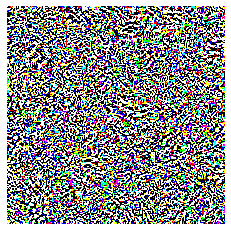

In [84]:
plt.imshow((p - mn) / (mx - mn))
plt.axis('off')
plt.savefig('pert_10_layer.jpg')

In [87]:
idx2label = get_idx2label_map('./labels.json')
img_idx = 5

In [107]:
img = next(iter(raw_dataloader_big))['image'][img_idx]
mx = img.max()
mn = img.min()
img = (img - mn) / (mx - mn)
img_class = idx2label[torch.argmax(mfe(img.unsqueeze(0).cuda()), dim=-1).item()]

In [108]:
img_pert = next(iter(pert_dataloader))['image'][img_idx]
mx = img_pert.max()
mn = img_pert.min()
img_pert = (img_pert - mn) / (mx - mn)
img_pert_class = idx2label[torch.argmax(mfe(img_pert.unsqueeze(0).cuda()), dim=-1).item()]

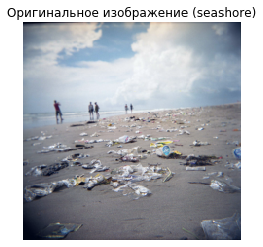

In [109]:
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Оригинальное изображение ({img_class})')
plt.savefig('seashore_orig.jpg')

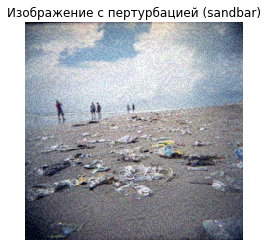

In [110]:
plt.imshow(img_pert.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Изображение с пертурбацией ({img_pert_class})')
plt.savefig('seashore_pert.jpg')

In [72]:
torch.argmax(mfe(img_pert.unsqueeze(0).cuda()), dim=-1)

tensor([103], device='cuda:0')

In [73]:
idx2label[394]

'sturgeon'

In [74]:
idx2label[103]

'platypus'